In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np

np.set_printoptions(precision=3, suppress=True)
# uncomment and replace with correct path if there are import errors
# sys.path.append("/path/to/surface-sampling/")
# sys.path.append("/path/to/NeuralForceField/")
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
# os.environ["LAMMPS_COMMAND"] ="/path/to/lammps/src/lmp_serial"
# os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

from mcmc import MCMC
from mcmc.system import SurfaceSystem

from time import perf_counter

/home/dux/NeuralForceField/models


Initialize test slab and parameters

In [3]:
# Load prepared pristine slab
element = "Ga"
slab_pkl = open("data/GaN_0001_3x3_pristine_slab.pkl", "rb")
slab = pickle.load(slab_pkl)

system_settings = {
    "surface_name": "GaN(0001)",
    "cutoff": 5.0,
    "num_ads_atoms": 12,
    "near_reduce": 0.01,
    "planar_distance": 1.5,
    "no_obtuse_hollow": True,
}

sampling_settings = {
    "alpha": 0.99,  # slowly anneal
    "temperature": 1.0,  # in terms of kbT
    "num_sweeps": 50,
    "sweep_size": 104,
}

calc_settings = {
    "calc_name": "LAMMPS",
    "optimizer": "LAMMPS",
    "chem_pots": {"Ga": 5},  # eV. arbitrary value
    "relax_atoms": True,
    "relax_steps": 100,
    "run_dir": "GaN(0001)",
}

Obtain adsorption sites

In [4]:
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
from pymatgen.io.ase import AseAtomsAdaptor

pristine_slab = slab.copy()
pristine_pmg_slab = AseAtomsAdaptor.get_structure(pristine_slab)
site_finder = AdsorbateSiteFinder(pristine_pmg_slab)

ads_positions = site_finder.find_adsorption_sites(
    put_inside=True,
    symm_reduce=False,
    near_reduce=system_settings["near_reduce"],
    distance=system_settings["planar_distance"],
    no_obtuse_hollow=system_settings["no_obtuse_hollow"],
)["all"]

print(f"adsorption coordinates are: {ads_positions[:5]}...")

adsorption coordinates are: [array([ 0.   ,  0.   , 14.766]), array([12.865,  7.428, 14.12 ]), array([12.865,  5.571, 14.766]), array([11.257,  4.642, 14.12 ]), array([ 1.608,  2.785, 14.766])]...


In [5]:
pristine_slab.get_tags()

array([4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1, 4, 3,
       2, 1, 4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1])

Set up LAMMPS (calculator). Requires a `lammps_config.json` and a `lammps_template.txt` in `run_dir`

In [6]:
from mcmc.calculators import LAMMPSSurfCalc

lammps_surf_calc = LAMMPSSurfCalc()
lammps_surf_calc.set(**calc_settings)

run directory: GaN(0001) is set from parameters
relaxation steps: 100 is set from parameters


Initialize surface system

In [7]:
surface = SurfaceSystem(
    pristine_slab,
    ads_positions,
    calc=lammps_surf_calc,
    surface_depth=1,
    system_settings=system_settings,
)
surface.all_atoms.write("GaN_0001_3x3_all_virtual_ads.cif")

2024-06-22 14:37:36,030|INFO|initializing 104 virtual atoms
2024-06-22 14:37:36,041|INFO|initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2024-06-22 14:37:36,042|INFO|number of pristine atoms is 36
2024-06-22 14:37:36,047|INFO|bulk indices are [ 1  2  3  5  6  7  9 10 11 13 14 15 17 18 19 21 22 23 25 26 27 29 30 31
 33 34 35]
2024-06-22 14:37:36,048|INFO|surface indices are [ 0  4  8 12 16 20 24 28 32]
2024-06-22 14:37:36,049|INFO|constraints are FixAtoms(indices=[1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 15, 17, 18, 19, 21, 22, 23, 25, 26, 27, 29, 30, 31, 33, 34, 35])


Total wall time: 0:00:00


Test calculate pristine surface

In [8]:
print(f"Energy {surface.get_potential_energy():.3f} eV")

Total wall time: 0:00:00
Energy -144.059 eV


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `GaN(0001)/` folder.

2024-06-22 14:37:36,376|INFO|there are 36 atoms in pristine slab
2024-06-22 14:37:36,378|INFO|Running with num_sweeps = 50, temp = 1.0, pot = [5], alpha = 0.99
2024-06-22 14:37:36,379|INFO|In pristine slab, there are a total of 104 sites
2024-06-22 14:37:36,387|INFO|randomly adsorbing sites


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:37:37,017|INFO|running for 104 iterations per run over a total of 50 runs
2024-06-22 14:37:37,018|INFO|starting with iteration 0
2024-06-22 14:37:37,019|INFO|In sweep 1 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
temp list is:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total w

2024-06-22 14:37:40,445|INFO|At iter 104
2024-06-22 14:37:40,509|INFO|optim structure has Energy = -177.6073139882806
2024-06-22 14:37:40,517|INFO|In sweep 2 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:37:43,473|INFO|At iter 208
2024-06-22 14:37:43,521|INFO|optim structure has Energy = -177.0474351423916
2024-06-22 14:37:43,529|INFO|In sweep 3 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:37:46,658|INFO|At iter 312


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:37:46,705|INFO|optim structure has Energy = -179.2211815784581
2024-06-22 14:37:46,710|INFO|In sweep 4 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:37:49,557|INFO|At iter 416
2024-06-22 14:37:49,599|INFO|optim structure has Energy = -178.85193787538316
2024-06-22 14:37:49,607|INFO|In sweep 5 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:37:52,162|INFO|At iter 520
2024-06-22 14:37:52,203|INFO|optim structure has Energy = -177.05726664969393
2024-06-22 14:37:52,209|INFO|In sweep 6 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:37:55,352|INFO|At iter 624
2024-06-22 14:37:55,409|INFO|optim structure has Energy = -178.2837328266386
2024-06-22 14:37:55,415|INFO|In sweep 7 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:37:58,066|INFO|At iter 728
2024-06-22 14:37:58,119|INFO|optim structure has Energy = -177.91574245019868
2024-06-22 14:37:58,124|INFO|In sweep 8 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:01,200|INFO|At iter 832
2024-06-22 14:38:01,242|INFO|optim structure has Energy = -176.9717936338953
2024-06-22 14:38:01,248|INFO|In sweep 9 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:04,213|INFO|At iter 936
2024-06-22 14:38:04,258|INFO|optim structure has Energy = -176.15634955630964
2024-06-22 14:38:04,264|INFO|In sweep 10 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:06,805|INFO|At iter 1040
2024-06-22 14:38:06,850|INFO|optim structure has Energy = -176.41685345707504
2024-06-22 14:38:06,860|INFO|In sweep 11 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:09,401|INFO|At iter 1144


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:09,447|INFO|optim structure has Energy = -177.58281355773286
2024-06-22 14:38:09,452|INFO|In sweep 12 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:11,957|INFO|At iter 1248


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:12,016|INFO|optim structure has Energy = -176.84503215607458
2024-06-22 14:38:12,021|INFO|In sweep 13 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:14,637|INFO|At iter 1352
2024-06-22 14:38:14,681|INFO|optim structure has Energy = -176.83028880328555
2024-06-22 14:38:14,686|INFO|In sweep 14 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:17,146|INFO|At iter 1456
2024-06-22 14:38:17,194|INFO|optim structure has Energy = -178.25731065903034
2024-06-22 14:38:17,199|INFO|In sweep 15 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:19,592|INFO|At iter 1560


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:19,646|INFO|optim structure has Energy = -173.96362942257124
2024-06-22 14:38:19,651|INFO|In sweep 16 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:22,128|INFO|At iter 1664
2024-06-22 14:38:22,173|INFO|optim structure has Energy = -177.2685014276996
2024-06-22 14:38:22,179|INFO|In sweep 17 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:24,638|INFO|At iter 1768
2024-06-22 14:38:24,676|INFO|optim structure has Energy = -176.29845537076153
2024-06-22 14:38:24,682|INFO|In sweep 18 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:27,342|INFO|At iter 1872
2024-06-22 14:38:27,387|INFO|optim structure has Energy = -177.3659874367494
2024-06-22 14:38:27,392|INFO|In sweep 19 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:29,924|INFO|At iter 1976
2024-06-22 14:38:29,971|INFO|optim structure has Energy = -177.38637939050005
2024-06-22 14:38:29,978|INFO|In sweep 20 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:32,483|INFO|At iter 2080


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:32,527|INFO|optim structure has Energy = -176.46033790086085
2024-06-22 14:38:32,533|INFO|In sweep 21 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:34,916|INFO|At iter 2184
2024-06-22 14:38:34,964|INFO|optim structure has Energy = -178.23380708869533
2024-06-22 14:38:34,970|INFO|In sweep 22 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:37,441|INFO|At iter 2288
2024-06-22 14:38:37,506|INFO|optim structure has Energy = -178.12832965385496
2024-06-22 14:38:37,512|INFO|In sweep 23 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:40,153|INFO|At iter 2392
2024-06-22 14:38:40,193|INFO|optim structure has Energy = -174.21288860912304
2024-06-22 14:38:40,203|INFO|In sweep 24 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:42,653|INFO|At iter 2496
2024-06-22 14:38:42,701|INFO|optim structure has Energy = -178.56759067592787
2024-06-22 14:38:42,710|INFO|In sweep 25 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:45,131|INFO|At iter 2600


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:45,190|INFO|optim structure has Energy = -176.76184237549262
2024-06-22 14:38:45,200|INFO|In sweep 26 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:47,624|INFO|At iter 2704


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:47,672|INFO|optim structure has Energy = -179.03552010524706
2024-06-22 14:38:47,677|INFO|In sweep 27 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:50,120|INFO|At iter 2808


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:50,175|INFO|optim structure has Energy = -177.11178265486802
2024-06-22 14:38:50,181|INFO|In sweep 28 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:52,747|INFO|At iter 2912


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:52,809|INFO|optim structure has Energy = -177.89976200627459
2024-06-22 14:38:52,814|INFO|In sweep 29 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:55,237|INFO|At iter 3016
2024-06-22 14:38:55,282|INFO|optim structure has Energy = -179.10010400570985
2024-06-22 14:38:55,287|INFO|In sweep 30 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:38:57,741|INFO|At iter 3120
2024-06-22 14:38:57,792|INFO|optim structure has Energy = -178.67975919009268
2024-06-22 14:38:57,803|INFO|In sweep 31 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:39:00,186|INFO|At iter 3224
2024-06-22 14:39:00,221|INFO|optim structure has Energy = -178.2605540375274
2024-06-22 14:39:00,231|INFO|In sweep 32 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:39:02,658|INFO|At iter 3328
2024-06-22 14:39:02,712|INFO|optim structure has Energy = -178.36427753707466
2024-06-22 14:39:02,718|INFO|In sweep 33 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:39:05,325|INFO|At iter 3432


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:39:05,381|INFO|optim structure has Energy = -175.13244275802285
2024-06-22 14:39:05,388|INFO|In sweep 34 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:39:07,873|INFO|At iter 3536


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:39:07,936|INFO|optim structure has Energy = -176.29672236441465
2024-06-22 14:39:07,942|INFO|In sweep 35 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:39:10,408|INFO|At iter 3640


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:39:10,455|INFO|optim structure has Energy = -179.60246728908362
2024-06-22 14:39:10,461|INFO|In sweep 36 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:39:12,952|INFO|At iter 3744


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:39:13,011|INFO|optim structure has Energy = -176.39514386206636
2024-06-22 14:39:13,016|INFO|In sweep 37 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:39:15,414|INFO|At iter 3848
2024-06-22 14:39:15,464|INFO|optim structure has Energy = -177.83248462938488


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:39:15,469|INFO|In sweep 38 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:39:18,116|INFO|At iter 3952
2024-06-22 14:39:18,162|INFO|optim structure has Energy = -177.13607388333202
2024-06-22 14:39:18,170|INFO|In sweep 39 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:39:20,599|INFO|At iter 4056
2024-06-22 14:39:20,653|INFO|optim structure has Energy = -179.04503937071166
2024-06-22 14:39:20,663|INFO|In sweep 40 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:39:23,189|INFO|At iter 4160
2024-06-22 14:39:23,241|INFO|optim structure has Energy = -175.40351054771565
2024-06-22 14:39:23,246|INFO|In sweep 41 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:39:25,649|INFO|At iter 4264
2024-06-22 14:39:25,708|INFO|optim structure has Energy = -174.5918703570912
2024-06-22 14:39:25,716|INFO|In sweep 42 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:39:28,137|INFO|At iter 4368
2024-06-22 14:39:28,181|INFO|optim structure has Energy = -176.53339323708664
2024-06-22 14:39:28,186|INFO|In sweep 43 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:39:30,779|INFO|At iter 4472
2024-06-22 14:39:30,814|INFO|optim structure has Energy = -172.92550053905887
2024-06-22 14:39:30,819|INFO|In sweep 44 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:39:33,339|INFO|At iter 4576
2024-06-22 14:39:33,387|INFO|optim structure has Energy = -177.21432909125662
2024-06-22 14:39:33,392|INFO|In sweep 45 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:39:35,879|INFO|At iter 4680
2024-06-22 14:39:35,919|INFO|optim structure has Energy = -177.81950391861758
2024-06-22 14:39:35,927|INFO|In sweep 46 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:39:38,400|INFO|At iter 4784
2024-06-22 14:39:38,443|INFO|optim structure has Energy = -179.17568653527738
2024-06-22 14:39:38,448|INFO|In sweep 47 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:39:40,870|INFO|At iter 4888
2024-06-22 14:39:40,920|INFO|optim structure has Energy = -177.75521335353656
2024-06-22 14:39:40,930|INFO|In sweep 48 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:39:43,607|INFO|At iter 4992
2024-06-22 14:39:43,667|INFO|optim structure has Energy = -177.23808165115722
2024-06-22 14:39:43,673|INFO|In sweep 49 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:39:46,085|INFO|At iter 5096
2024-06-22 14:39:46,122|INFO|optim structure has Energy = -176.40489731037152
2024-06-22 14:39:46,134|INFO|In sweep 50 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-22 14:39:48,533|INFO|At iter 5200
2024-06-22 14:39:48,582|INFO|optim structure has Energy = -177.0845963881578


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Time taken = 132.51803275942802 seconds


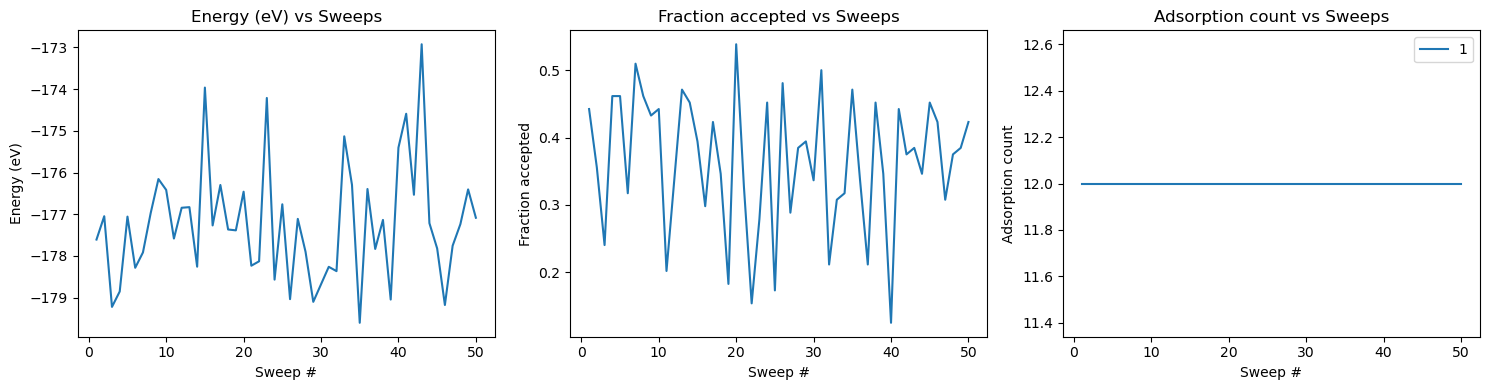

In [9]:
mcmc = MCMC(
    system_settings["surface_name"],
    calc=lammps_surf_calc,
    canonical=True,
    testing=False,
    element=element,
    adsorbates=list(calc_settings["chem_pots"].keys()),
    relax=calc_settings["relax_atoms"],
    relax_steps=calc_settings["relax_steps"],
    optimizer=calc_settings["optimizer"],
    num_ads_atoms=system_settings["num_ads_atoms"],
)

start = perf_counter()
# TODO: convert input to sampling settings
mcmc.mcmc_run(
    total_sweeps=sampling_settings["num_sweeps"],
    sweep_size=sampling_settings["sweep_size"],
    start_temp=sampling_settings["temperature"],
    pot=list(calc_settings["chem_pots"].values()),
    alpha=sampling_settings["alpha"],
    surface=surface,
)
stop = perf_counter()
print(f"Time taken = {stop - start} seconds")